# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
### No lateral constraints
### Fixed layers

In [1]:
#%matplotlib notebook

In [2]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [14]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers =[offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets, offsets*0, height]

# Frequency

freq = 9000

In [15]:
# parameters for the synthetic model

nlayer = 40 # number of layer
npos = 20 # number of sampling positions

resistivities = 10
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)
depth = np.linspace(0, 10, nlayer)

# Define a middle resistive layer:
depth1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
depth2 = depth1 + 2 + np.sin(x*np.pi*2) # wave


for i in range(npos):
    for j in range(nlayer):
        if (depth[j] >= depth1[i]) and (depth[j] <= depth2[i]):
            res[i, j] = 50
        

In [16]:

def PlotResistivities(res, npos, nlayer, Modelname):       
    
    fig, ax = plt.subplots()
    pos = ax.imshow(res.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Modelname)
        
    return 

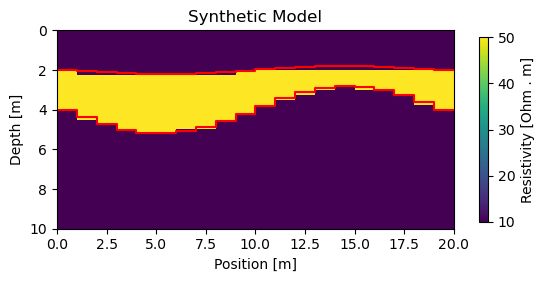

In [17]:
#Plot synthetic model

xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

PlotResistivities(res, npos, nlayer, 'Synthetic Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')


In [18]:
# Parameters for initial model

resistivities_ini = 10
res_ini = np.ones((npos, nlayer))*resistivities_ini


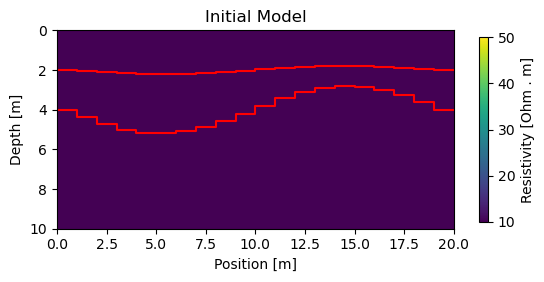

In [19]:
# Plot initial model

PlotResistivities(res_ini, npos, nlayer, 'Initial Model')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')

In [20]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, res):
        surface = np.array([0])
        depthx = np.hstack((surface, depth[:-1]))
        res_air = np.array([2e14])
        resx = np.hstack((res_air, res))
        HCP_Hs = empymod.loop(Hsource, Hreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        VCP_Hs = empymod.loop(Vsource, Vreceivers, depthx, resx, freq, xdirect=None, mrec = 'loop', verb=0)
        PRP_Hs = empymod.dipole(Psource, Preceivers, depthx, resx, freq, ab = 64, xdirect = None, verb = 0)
    
        HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=res_air[0], freqtime=freq, mrec = 'loop', verb=0)
        VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=res_air[0], freqtime=freq, mrec = 'loop', verb=0)
        PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=res_air[0], freqtime = freq, ab = 66, verb = 0)

        Q_HCP = np.abs(np.imag(HCP_Hs/HCP_Hp))
        Q_VCP = np.abs(np.imag(VCP_Hs/VCP_Hp))
        Q_PRP = np.abs(np.imag(PRP_Hs/PRP_Hp))

        P_HCP = np.abs(np.real(HCP_Hs/HCP_Hp))
        P_VCP = np.abs(np.real(VCP_Hs/VCP_Hp))
        P_PRP = np.abs(np.real(PRP_Hs/PRP_Hp))
        
        # Normalize values by distance

        Q_HCP[0] = Q_HCP[0]*16
        Q_HCP[1] = Q_HCP[1]*4
        Q_VCP[0] = Q_VCP[0]*16
        Q_VCP[1] = Q_VCP[1]*4
        Q_PRP[0] = Q_PRP[0]*16
        Q_PRP[1] = Q_PRP[1]*4

        P_HCP[0] = P_HCP[0]*16*4
        P_HCP[1] = P_HCP[1]*4*2
        P_VCP[0] = P_VCP[0]*16*4*2
        P_VCP[1] = P_VCP[1]*4*2*2
        P_VCP[2] = P_VCP[2]*2
        P_PRP[0] = P_PRP[0]*16*4*4
        P_PRP[1] = P_PRP[1]*4*2*4
        P_PRP[2] = P_PRP[2]*4
           
        return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))
        
    def createStartModel(self, dataVals):
        
        res_ini = np.ones(nlayer)*10
        return res_ini

Set-up Inversion

In [21]:
# Define inversion transformations

transData = pg.trans.TransLog() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [22]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = res[i] # True model 
    model.append(model_i)
    data.append(EMf(model_i)) # creating data

# Relative error array
error = 1e-2 # introduce here the error you want to test
relativeError = np.ones_like(data[0]) * error

In [23]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = np.array(data[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=False, lam=1, maxIter=40, dPhi=0.01)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

11/11/22 - 16:45:40 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
11/11/22 - 16:45:53 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:00 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:07 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:17 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:28 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:40 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:46:52 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
11/11/22 - 16:47:05 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
11/11/22 - 16:47:14 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:47:27 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:47:39 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
11/11/22 - 16:47:51 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:48:02 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:48:11 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:48:27 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:48:35 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:48:44 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


11/11/22 - 16:49:04 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]
11/11/22 - 16:49:17 - pyGIMLi - INFO - Created startmodel from forward operator: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10.]


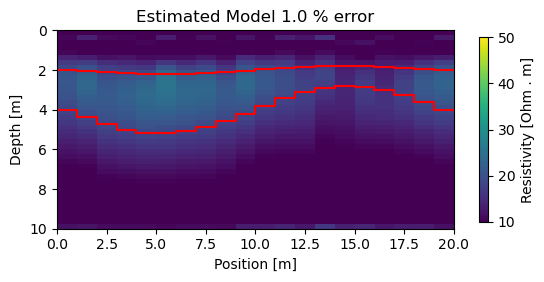

In [24]:
# Plot estimated model


PlotResistivities(model_est_arr, npos, nlayer, 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx)), np.hstack((depth1[0], depth1)), 'r')
plt.step(np.hstack((xx)), np.hstack((depth2[0], depth2)), 'r')